## GP for MNIST
In this notebook we learn a MLP on MNIST and formulate the problem of classification in a Bayesian setting. We learn a GP prior on the MNIST dataset and combine the learned embeddings with the learned MLP logits. 
We observe an accuracy increase of almost 2% on average.
The barebone code is taken from: https://gist.github.com/hhl60492/6eaa55a9518893d4b89871a550e3e621#file-tf_2-py  
However, the code is changed and we remove the KL-loss in addition to changing the dataset to images (MNIST, in this case). Furthermore, we formulate the setting in a Bayesian fashion.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
bc = datasets.load_digits()
X = bc.data[:, :]
Y = bc.target
classes = set(Y)
print(X.shape, Y.shape)
scaler = MinMaxScaler()
onehot_encoder = OneHotEncoder(sparse=False)
X = scaler.fit_transform(X,Y)
label = LabelBinarizer()
Y = label.fit_transform(Y)
frac = 0.9
idx = np.random.randint(X.shape[0], size=len(X))
X = X[idx]
Y = Y[idx]
train_stop = int(len(X) * frac)
X_ = X[:train_stop]
Y_ = Y[:train_stop]
print(len(X_), len(Y_))
X_t = X[train_stop:]
Y_t = Y[train_stop:]
print(len(X_t), len(Y_t))
print(X_.shape, Y_.shape)

(1797, 64) (1797,)
1617 1617
180 180
(1617, 64) (1617, 10)


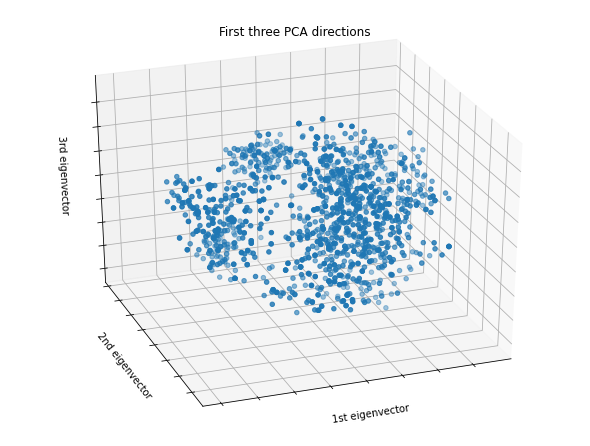

In [3]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(X_)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2])
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])
plt.show()

In [0]:
training_epochs = 200
n_neurons_in_h1 = 10
n_neurons_in_h2 = 10
learning_rate = 0.1
batch_size = 16
n_features = len(X[0])
labels_dim = 10

In [5]:
# Fitting a GP on the entire dataset
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

kernel = 1.0 * RBF(1.0)
print(X_.shape, Y_.shape)
gpc = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_, Y_)

# lets see how good our fit on the train set is
print(gpc.score(X_, Y_))

(1617, 64) (1617, 10)
1.0


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


In [6]:
training_epochs = 200
n_neurons_in_h1 = 10
n_neurons_in_h2 = 10
learning_rate = 0.01
dkl_loss_rate = 0.1
n_features = len(X[0])
labels_dim = 10
idx = np.random.randint(X_.shape[0], size=batch_size)
X_b = X_[idx]
Y_b = Y_[idx]
Y_g = gpc.predict(X_b)
print(Y_g.shape)
print(Y_b.shape)
print(X_b.shape)

(16, 10)
(16, 10)
(16, 64)


In [0]:
x = tf.placeholder(tf.float32, [None, n_features], name='input')
y = tf.placeholder(tf.float32, [None, 10], name='labels')
# input tensor for our reference model predictions
y_g = tf.placeholder(tf.float32, [None, 10], name='labels')

# TF Variables are our neural net parameter tensors, we initialize them to random (gaussian) values in
# Layer1. Variables are allowed to be persistent across training epochs and updatable bt TF operations
W1 = tf.Variable(tf.truncated_normal([n_features, n_neurons_in_h1], mean=0, stddev=1 / np.sqrt(n_features)),
                 name='weights1')
b1 = tf.Variable(tf.truncated_normal([n_neurons_in_h1], mean=0, stddev=1 / np.sqrt(n_features)), name='biases1')

# note the output tensor of the 1st layer is the activation applied to a
# linear transform of the layer 1 parameter tensors
# the matmul operation calculates the dot product between the tensors
y1 = tf.sigmoid((tf.matmul(x, W1) + b1), name='activationLayer1')

# network parameters(weights and biases) are set and initialized (Layer2)
W2 = tf.Variable(tf.random_normal([n_neurons_in_h1, n_neurons_in_h2], mean=0, stddev=1),
                 name='weights2')
b2 = tf.Variable(tf.random_normal([n_neurons_in_h2], mean=0, stddev=1), name='biases2')
# activation function(sigmoid)
y2 = tf.sigmoid((tf.matmul(y1, W2) + b2), name='activationLayer2')

# output layer weights and biases
Wo = tf.Variable(tf.random_normal([n_neurons_in_h2, labels_dim], mean=0, stddev=1 ),
                 name='weightsOut')
bo = tf.Variable(tf.random_normal([labels_dim], mean=0, stddev=1), name='biasesOut')

logits = (tf.matmul(y2, Wo) + bo)
logits = logits + y_g
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = logits)
a = tf.nn.softmax(logits, name='activationOutputLayer')

train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
correct_prediction = tf.equal(tf.round(a), y)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name="Accuracy")
init_op = tf.global_variables_initializer()

In [16]:
with tf.Session() as sess:
    sess.run(init_op)
    batch_size = 5
    batches = int(len(X_) / batch_size)

    for epoch in range(10):
        losses = 0
        dkl_losses = 0
        accs = 0
        for j in range(batches):
            idx = np.random.randint(X_.shape[0], size=batch_size)
            X_b = X_[idx]
            Y_b = Y_[idx]
            Y_g = gpc.predict(X_b)

            # train the network, note the dictionary of inputs and labels
            sess.run(train_step, feed_dict={x: X_b, y: Y_b, y_g: Y_g})
            # feedforwad the same data and labels, but grab the accuracy and loss as outputs
            acc, l, soft_max_a = sess.run([accuracy, loss, a], feed_dict={x: X_b, y: Y_b, y_g: Y_g})

            losses = losses + np.sum(l)
            accs = accs + np.sum(acc)
        print("Epoch %.1d " % epoch, "avg train loss over", batches, " batches ", "%.4f" % (losses/batches), "avg train acc ", "%.4f" % (accs/batches))

        Y_g = gpc.predict(X_t)

        acc, l, soft_max_a = sess.run([accuracy, loss, a], feed_dict={x: X_t, y: Y_t, y_g: Y_g})
        print("Epoch %.1d " % epoch, "test loss %.4f" % np.sum(l), "test acc %.4f" % acc)


print(soft_max_a)

Epoch 0  avg train loss over 323  batches  12.3746 avg train acc  0.9001
Epoch 0  test loss 417.0063 test acc 0.9000
Epoch 1  avg train loss over 323  batches  10.5694 avg train acc  0.9028
Epoch 1  test loss 375.4669 test acc 0.9161
Epoch 2  avg train loss over 323  batches  9.4900 avg train acc  0.9221
Epoch 2  test loss 340.2009 test acc 0.9228
Epoch 3  avg train loss over 323  batches  8.6602 avg train acc  0.9326
Epoch 3  test loss 318.9459 test acc 0.9294
Epoch 4  avg train loss over 323  batches  8.0461 avg train acc  0.9381
Epoch 4  test loss 294.8650 test acc 0.9383
Epoch 5  avg train loss over 323  batches  7.4958 avg train acc  0.9468
Epoch 5  test loss 272.6505 test acc 0.9522
Epoch 6  avg train loss over 323  batches  7.0203 avg train acc  0.9573
Epoch 6  test loss 254.2278 test acc 0.9583
Epoch 7  avg train loss over 323  batches  6.4542 avg train acc  0.9684
Epoch 7  test loss 237.6616 test acc 0.9711
Epoch 8  avg train loss over 323  batches  5.9139 avg train acc  0.978